# Tech Challenge - Desenvolvimento de um modelo de Machine Learning para prever custos médicos

Para iniciar o tech challenge eu escolhi uma base no kaggle chamada "Medical Cost Personal Datasets".

Importação das bibliotecas necessárias

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

%matplotlib inline

Carregar a base de dados e analisar as primeiras linhas para entender o conteúdo

In [8]:
dados = pd.read_csv('./data/insurance.csv')

dados.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


 Verificar os tipos de dados e valores ausentes

In [9]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [12]:
dados.shape

(1338, 7)

## Verificar a distribuição dos dados numéricos

In [ ]:
dados.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Verificar a distribuição dos dados categóricos visualmente para detectar possíveis outliers

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

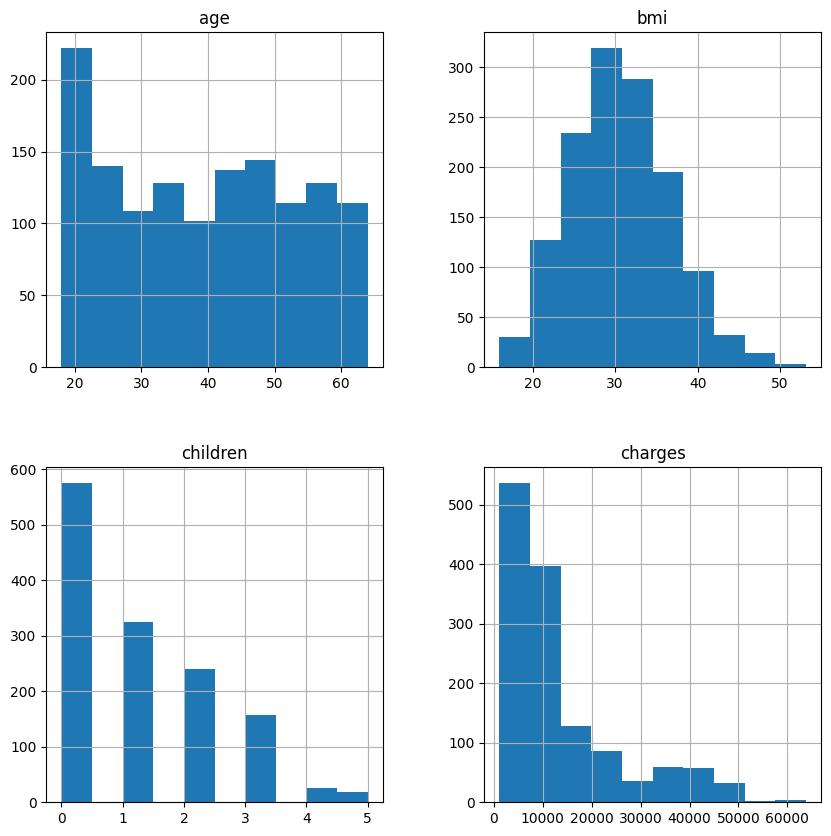

In [13]:
dados.hist(figsize=(10, 10))

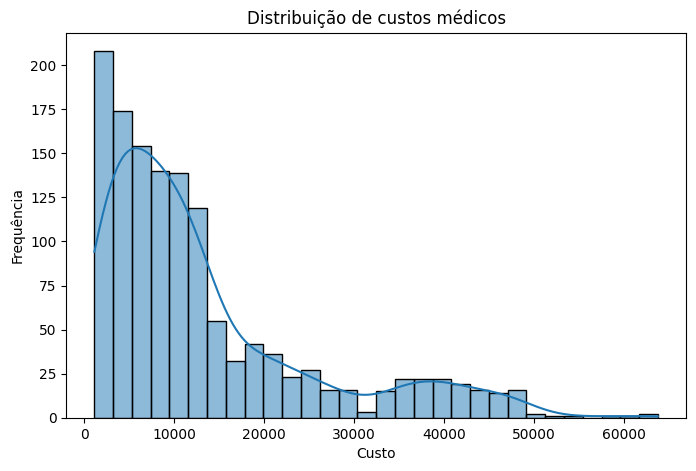

In [26]:
#  Distribuição de Custos médicos
plt.figure(figsize=(8, 5))
sns.histplot(dados['charges'], bins=30, kde=True)
plt.title('Distribuição de custos médicos')
plt.xlabel('Custo')
plt.ylabel('Frequência')
plt.show()

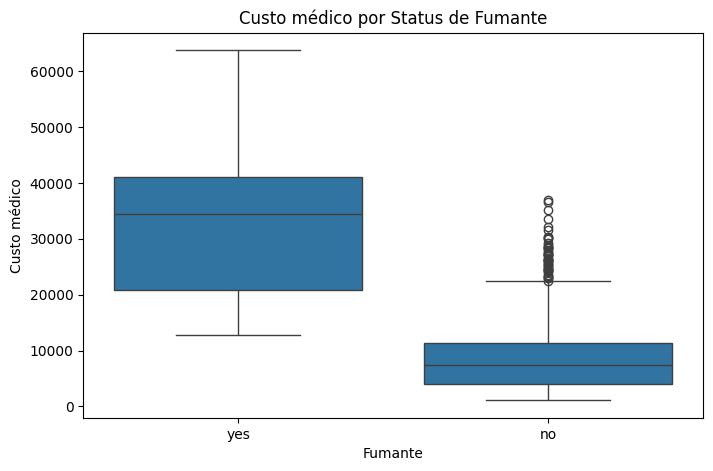

In [25]:
# Boxplot de Custo médico por Fumante
plt.figure(figsize=(8, 5))
sns.boxplot(data=dados, x='smoker', y='charges')
plt.title('Custo médico por Status de Fumante')
plt.xlabel('Fumante')
plt.ylabel('Custo médico')
plt.show()

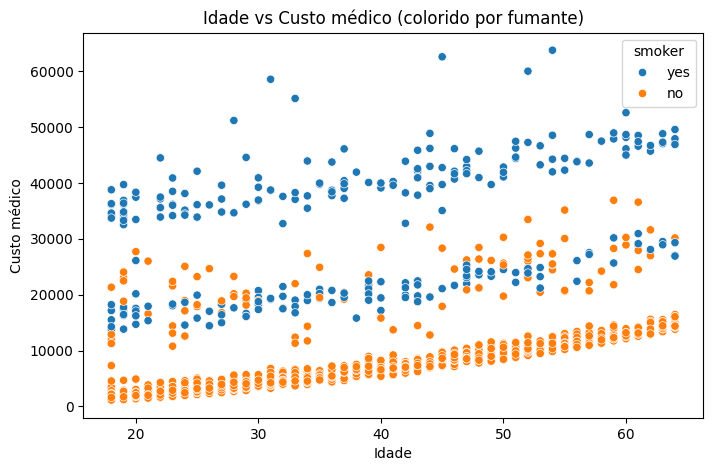

In [29]:
# Relação entre Idade e Charges
plt.figure(figsize=(8, 5))
sns.scatterplot(data=dados, x='age', y='charges', hue='smoker')
plt.title('Idade vs Custo médico (colorido por fumante)')
plt.xlabel('Idade')
plt.ylabel('Custo médico')
plt.show()


Aqui podemos ver a correlação entre as variáveis numéricas. Aqui, usamos o método de Pearson para calcular a correlação de Pearson. Escolhi a de Pearson pois esses dados são contínuos ou discretos numericos.

Podemos também avaliar com o resultado do heatmap que a idade possui uma correlação positiva forte com o gasto médico.

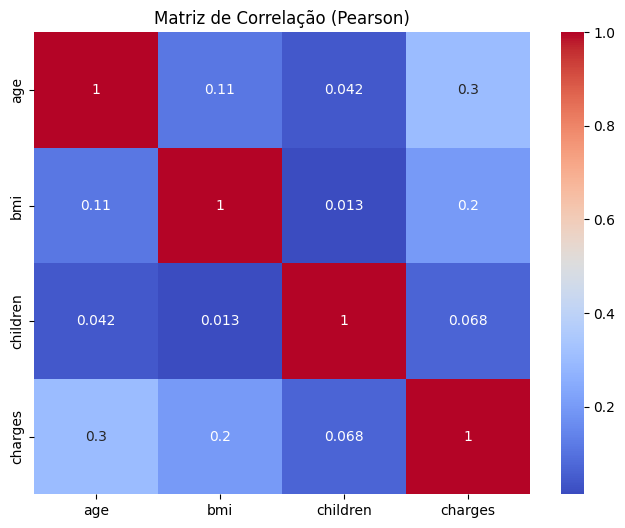

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(dados.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação (Pearson)')
plt.show()


No comando abaixo, verificamos a quantidade de pacientes por gênero. podemos ver que a quantidade dos dois é basicamente igual.

In [17]:
dados["sex"].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

Nos proximos dois graficos verificamos que a região não tem uma relação significativa com o gasto médico ou se é ou não fumante.

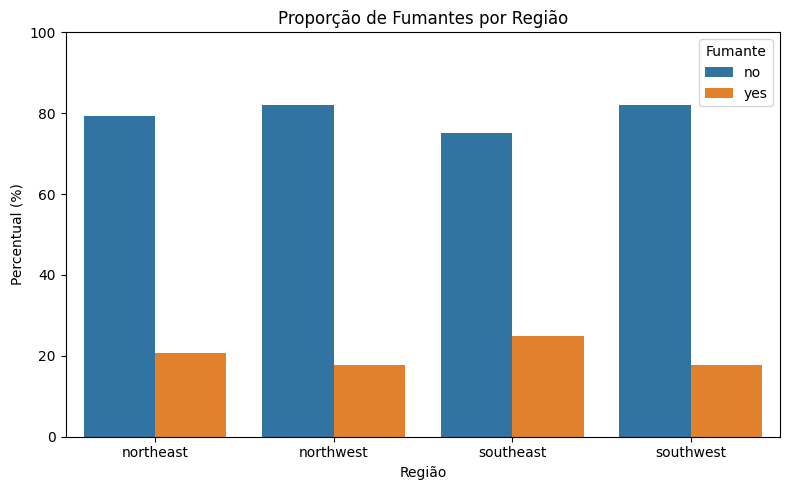

In [30]:
# Tabela de proporções por região
smoker_region_pct = pd.crosstab(dados['region'], dados['smoker'], normalize='index') * 100
smoker_region_pct = smoker_region_pct.round(2)

# Resetar índice para plotagem
smoker_region_pct = smoker_region_pct.reset_index()

# Converter para formato long (melt) para usar no seaborn
smoker_region_long = smoker_region_pct.melt(id_vars='region', var_name='smoker', value_name='percent')

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=smoker_region_long, x='region', y='percent', hue='smoker')
plt.title('Proporção de Fumantes por Região')
plt.ylabel('Percentual (%)')
plt.xlabel('Região')
plt.legend(title='Fumante')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

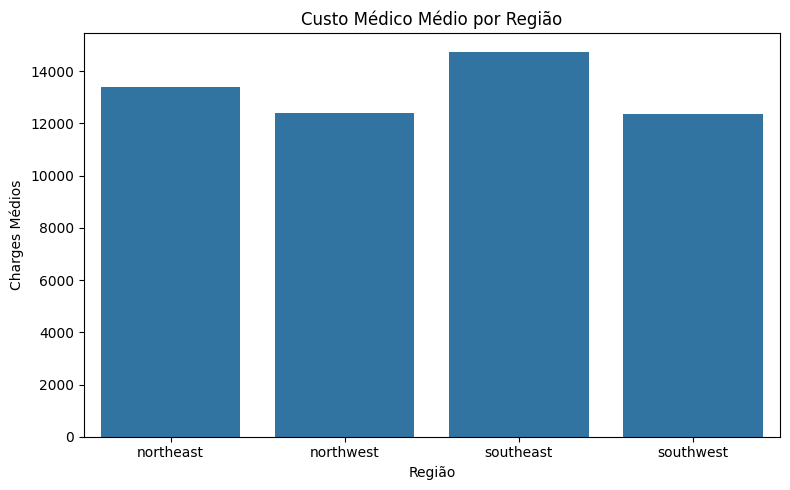

In [31]:
# Calcular custo médio por região
mean_charges_region = dados.groupby('region')['charges'].mean().reset_index()

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=mean_charges_region, x='region', y='charges')
plt.title('Custo Médico Médio por Região')
plt.ylabel('Charges Médios')
plt.xlabel('Região')
plt.tight_layout()
plt.show()

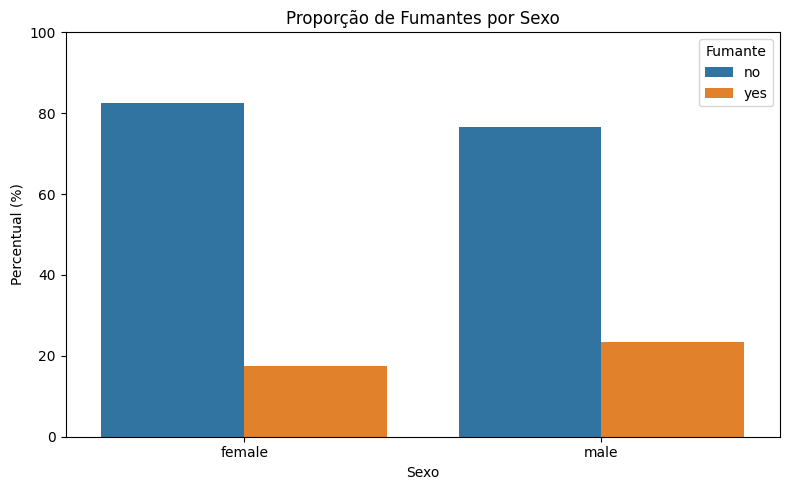

In [32]:
# Tabela de proporção de fumantes por sexo
smoker_sex_pct = pd.crosstab(dados['sex'], dados['smoker'], normalize='index') * 100
smoker_sex_pct = smoker_sex_pct.reset_index().melt(id_vars='sex', var_name='smoker', value_name='percent')

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=smoker_sex_pct, x='sex', y='percent', hue='smoker')
plt.title('Proporção de Fumantes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.legend(title='Fumante')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

Agora faremos a divisão dos dados em treino e teste e dos dados alvo (target)

In [51]:
X = dados.drop("charges", axis=1)
y = dados["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Pré-processamento dos dados

In [52]:
categorical_cols = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough' 
)


Optei por fazer uma validação cruzada para descobrir o melhor modelo. Escolhi um que não foi abordado nas aulas.

In [ ]:
# Definir os modelos
models = {
    'Regressão Linear': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0)
}

In [80]:
# Avaliar resultados
results = []
for name, reg in models.items():
    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('regressor', reg)
    ])
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    results.append({
        'Modelo': name,
        'R² Médio': scores.mean(),
        'Desvio Padrão': scores.std()
    })

# Exibir resultados
df_results = pd.DataFrame(results).sort_values(by='R² Médio', ascending=False)
print(df_results)


             Modelo  R² Médio  Desvio Padrão
1     Random Forest  0.850360       0.031564
2  Ridge Regression  0.746867       0.024525
0  Regressão Linear  0.746862       0.024874


Aqui vemos que o random forest teve o melhor resultado, com um R² médio de 0.83 e um desvio padrão de 0.03.

Agora vamos treinar o modelo com todos os dados, fazer previsões com os dados de teste e comparar com os valores reais.

A fins apenas de estudo vou repetir a separação dos dados, treinamento e teste e o modelo.

In [78]:
X = dados.drop('charges', axis=1)
y = dados['charges']

# Categóricas
categorical_cols = ['sex', 'smoker', 'region']

# Pré-processamento
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
], remainder='passthrough')


# Pipeline com Random Forest
model = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42))
])

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Métricas
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)


print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.872
RMSE: 4463.59
MAE: 2482.43


Agora plotaremos um grafico de dispersão dos valores reais e previstos.

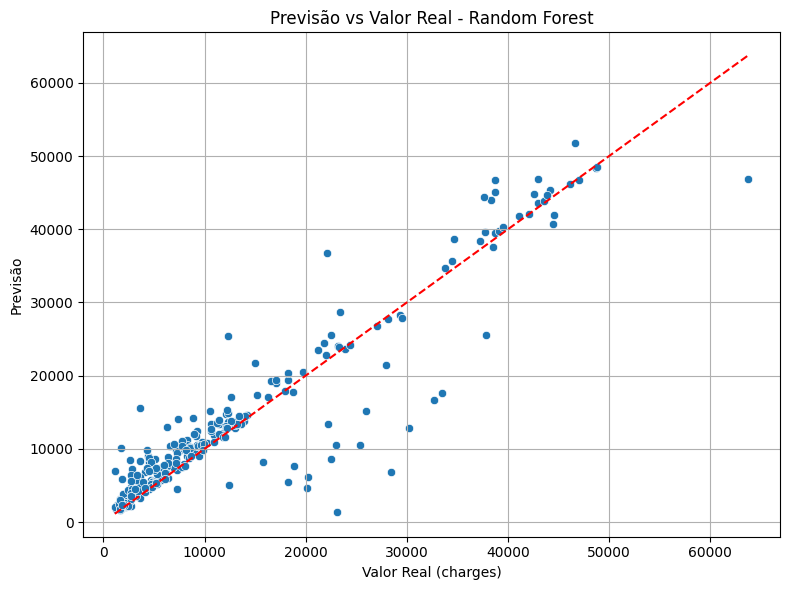

In [58]:
# Gráfico: Previsão vs Valor Real
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Valor Real (charges)')
plt.ylabel('Previsão')
plt.title('Previsão vs Valor Real - Random Forest')
plt.grid(True)
plt.tight_layout()
plt.show()


Agora um grafico de resíduos.

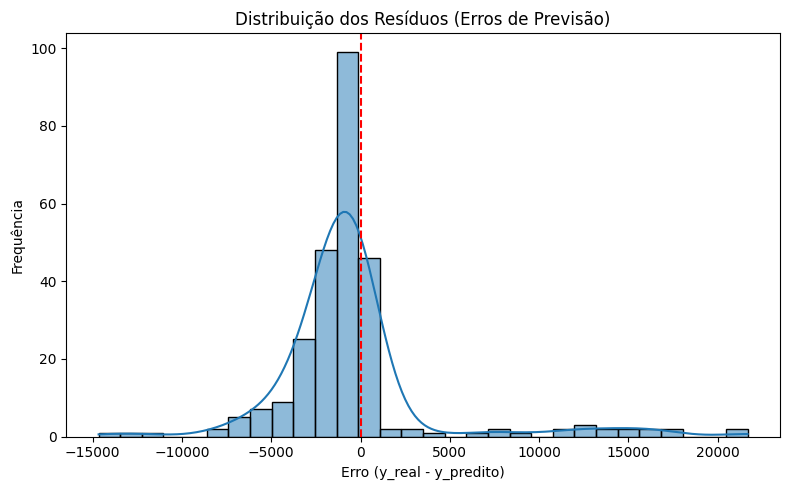

In [ ]:
residuos = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuos, bins=30, kde=True)
plt.title('Distribuição dos Resíduos (Erros de Previsão)')
plt.xlabel('Erro (y_real - y_predito)')
plt.ylabel('Frequência')
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


##  Análise dos Resultados

- O modelo **Random Forest** alcançou um R² de aproximadamente **87%**, o que indica uma explicação robusta da variabilidade nos custos médicos.
- O erro médio (MAE) está em torno de **R$ 2.482**, o que representa **~19% do valor médio** de `charges`.
- O RMSE de cerca de **R$ 4.464** mostra que, apesar de alguns erros maiores (outliers), o modelo tem desempenho sólido.
- O gráfico de resíduos mostra uma distribuição aproximadamente normal, centrada em zero, indicando **ausência de viés sistemático**.
- A linha de referência no gráfico "previsão vs. real" mostra boa aderência geral — quanto mais pontos próximos da linha, melhor o ajuste.

### Conclusão:
- O modelo está **estatisticamente consistente e eficaz**.
- Pode ser considerado confiável para auxiliar em decisões de precificação de seguros.
